# Inter-Maimi - PROD Retention Score _ all teams
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_all_teams] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(60061, 52)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60061 entries, 0 to 60060
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dimCustomerMasterId     60061 non-null  int64  
 1   year                    60061 non-null  int64  
 2   productGrouping         60061 non-null  object 
 3   totalSpent              60061 non-null  float64
 4   recentDate              60061 non-null  object 
 5   attendancePercent       60061 non-null  float64
 6   renewedBeforeDays       60040 non-null  float64
 7   isBuyer                 60061 non-null  object 
 8   source_tenure           60040 non-null  float64
 9   tenure                  60040 non-null  float64
 10  distToVenue             60061 non-null  float64
 11  totalGames              60061 non-null  int64  
 12  recency                 60061 non-null  int64  
 13  missed_games_1          60061 non-null  int64  
 14  missed_games_2          60061 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (43283, 15)
Unseen Data For Predictions: (7638, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm","lr","xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7793,0.8270,0.8998,0.7843,0.8381,0.4968,0.5086,0.4650
xgboost,Extreme Gradient Boosting,0.7760,0.8234,0.8866,0.7873,0.8340,0.4933,0.5017,1.8000
lr,Logistic Regression,0.7325,0.7564,0.8851,0.7427,0.8077,0.3793,0.3956,0.9340


In [8]:
lightgbm_model = create_model('lightgbm')
lr_model = create_model('lr')
xgboost_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7782,0.8235,0.8976,0.7841,0.8371,0.4947,0.5059
1,0.7679,0.8152,0.8754,0.7840,0.8272,0.4770,0.4837
2,0.7845,0.8262,0.8848,0.7977,0.8390,0.5157,0.5220
3,0.7744,0.8234,0.8814,0.7882,0.8322,0.4913,0.4985
4,0.7755,0.8180,0.8908,0.7846,0.8343,0.4904,0.5000
5,0.7842,0.8283,0.8951,0.7920,0.8404,0.5111,0.5203
6,0.7768,0.8283,0.8869,0.7881,0.8346,0.4954,0.5037
7,0.7763,0.8251,0.8831,0.7894,0.8336,0.4955,0.5028
8,0.7703,0.8265,0.8903,0.7792,0.8310,0.4774,0.4879
9,0.7717,0.8194,0.8809,0.7853,0.8304,0.4847,0.4923


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
cursor = CNXN.cursor()

storedProc_scoring = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_staging2] """
)

df_scoring = pd.read_sql(storedProc_scoring, CNXN)

# apply some data transformations
df_scoring["year"] = pd.to_numeric(df_scoring["year"])

CNXN.commit()
cursor.close()

df_scoring.shape

(3947, 15)

In [10]:
df_inference = df_scoring.loc[df_scoring["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(1109, 15)

In [11]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)
lr_predictions = predict_model(lr_model, data=df_inference, raw_score=True)
xgboost_predictions = predict_model(xgboost_model, data=df_inference, raw_score=True)

In [12]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")
print(f"log reg:\n {lr_predictions.Label.value_counts()}")
print(f"xgboost:\n {xgboost_predictions.Label.value_counts()}")

lightgbm:
 0    809
1    300
Name: Label, dtype: int64
log reg:
 0    836
1    273
Name: Label, dtype: int64
xgboost:
 0    934
1    175
Name: Label, dtype: int64


In [13]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")
print(f"lr:\n {lr_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")
print(f"xgboost:\n {xgboost_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (0.25, 0.5]       485
(-0.001, 0.25]    324
(0.5, 0.75]       292
(0.75, 1.0]         8
Name: Score_1, dtype: int64
lr:
 (0.25, 0.5]       543
(-0.001, 0.25]    293
(0.5, 0.75]       259
(0.75, 1.0]        14
Name: Score_1, dtype: int64
xgboost:
 (-0.001, 0.25]    506
(0.25, 0.5]       428
(0.5, 0.75]       151
(0.75, 1.0]        24
Name: Score_1, dtype: int64


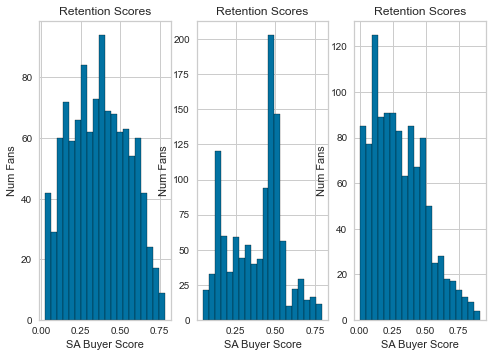

In [14]:
model_predictions = [lightgbm_predictions, lr_predictions, xgboost_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

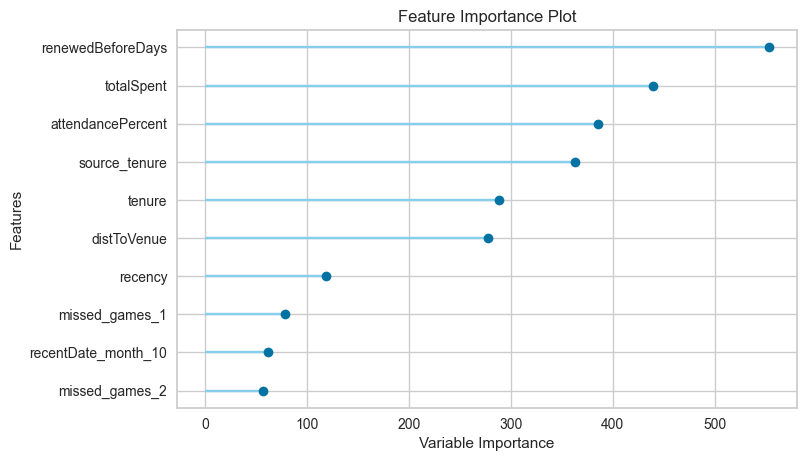

In [15]:
plot_model(lightgbm_model, plot='feature')

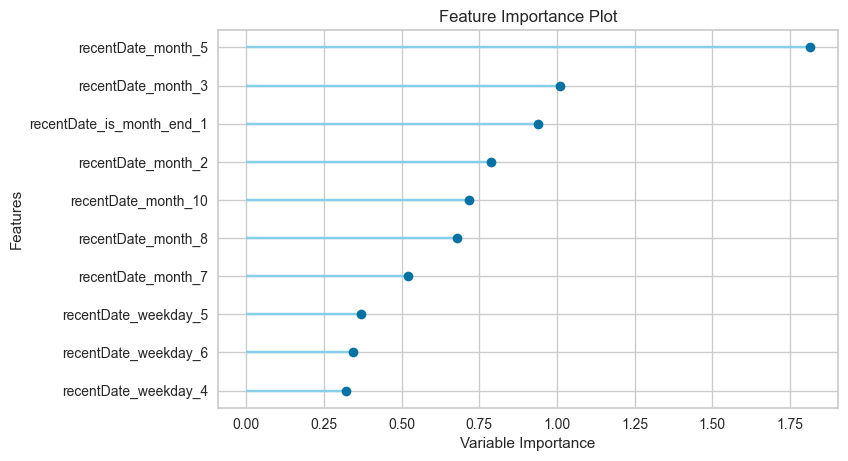

In [16]:
plot_model(lr_model, plot='feature')

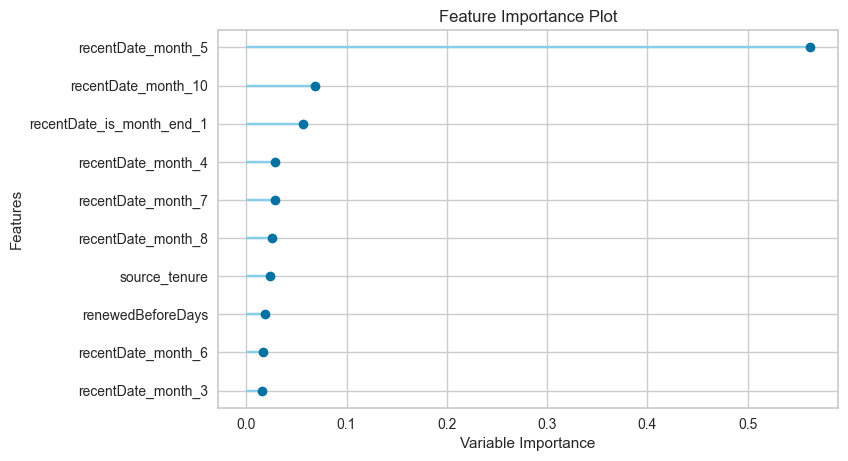

In [17]:
plot_model(xgboost_model, plot='feature')

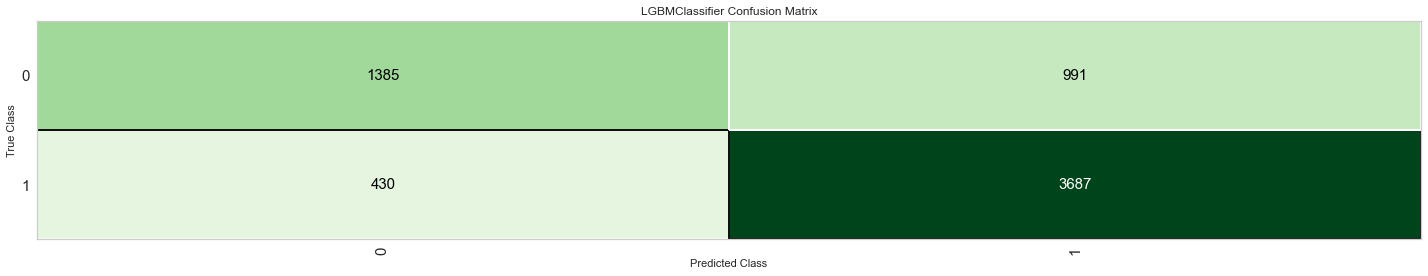

In [18]:
plot_model(lightgbm_model, plot='confusion_matrix')

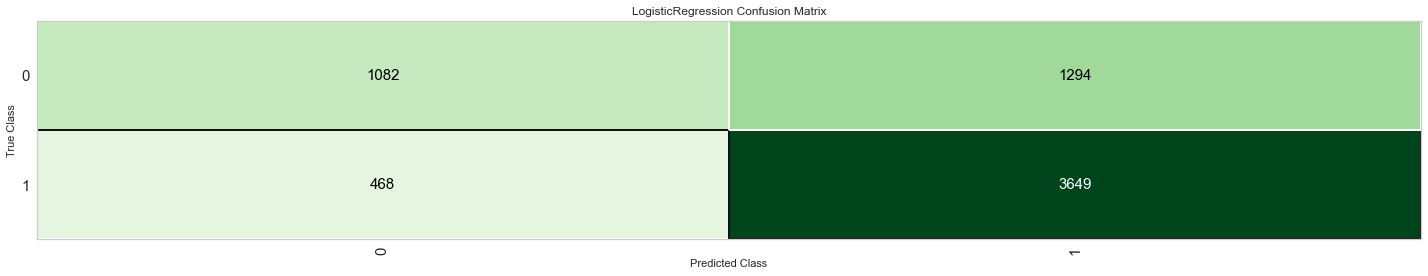

In [19]:
plot_model(lr_model, plot='confusion_matrix')

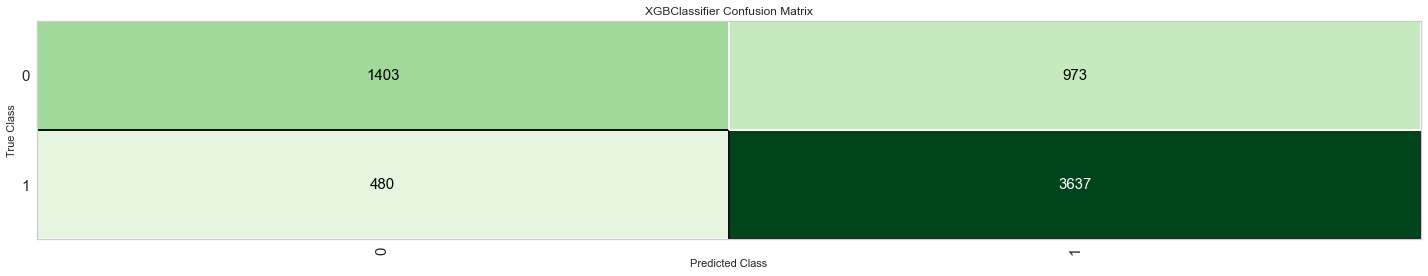

In [20]:
plot_model(xgboost_model, plot='confusion_matrix')

In [21]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,42,2022,Flex Plan,312.00,2022-06-25,0.38,10,730,150,38.20,1,1,0,0,0,0,0.8676,0.1324
4,238,2022,Half Season,466.00,2022-05-14,0.60,6,365,217,14.62,2,0,1,0,0,0,0.9703,0.0297
6,313,2022,Full Season,1267.50,2022-03-12,1.00,103,365,103,3764.39,0,0,0,0,0,0,0.5763,0.4237
8,322,2022,Full Season,875.50,2022-06-25,0.60,159,1095,1054,29.38,1,2,1,0,0,0,0.5287,0.4713
15,454,2022,Full Season,700.40,2022-06-25,0.30,162,1095,1087,23.14,1,1,0,1,0,0,0.5452,0.4548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,235740,2022,Full Season,405.00,2022-04-24,1.00,0,365,59,50.84,0,0,0,0,0,0,0.7687,0.2313
3940,238726,2022,Full Season,1912.72,2022-06-25,0.58,1,0,135,8.55,1,1,0,0,0,0,0.9258,0.0742
3942,241919,2022,Full Season,3187.32,2022-06-25,0.75,5,0,145,56.49,1,1,0,0,0,0,0.9232,0.0768
3944,244313,2022,Full Season,1575.90,2022-05-14,0.30,162,1095,1094,38.86,4,0,0,2,0,0,0.5984,0.4016


In [22]:

current_date = datetime.today().strftime('%Y-%m-%d')
lightgbm_predictions.to_csv(f"results/InterMiami_Retention_Scores_{current_date}.csv", index=False)

## Observations
Here you can document some ideas on the results from above